In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline,make_pipeline
#from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from datetime import datetime
from datetime import timedelta
from datetime import timezone
from datetime import time
import os
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling  import SMOTE
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
def model(cv, train_feature, train_label, test_feature, name):
    model = XGBClassifier()
    k_cv = StratifiedKFold(n_splits= cv, random_state= 42, shuffle = True)
    print(cross_val_score(model, train_feature, train_label, cv=k_cv, scoring= 'roc_auc'))
    print(cross_val_score(model, train_feature, train_label, cv=k_cv, scoring= 'roc_auc').mean())
    model.fit(train_feature, train_label)
    print(model.feature_importances_)
    model.fit(train_feature, train_label)
    test_label = model.predict(test_feature)
    submission = pd.DataFrame({
    "order_id" :  test['order_id'],
    "deal_or_not" : test_label
    })
    submission.to_csv(name, index=False)

# Pre-processing

In [3]:
airline      = pd.read_csv('airline.csv')
day_schedule = pd.read_csv('day_schedule.csv')
group        = pd.read_csv('group.csv')
order        = pd.read_csv('order.csv')
training     = pd.read_csv('training-set.csv')
testing     = pd.read_csv('testing-set.csv')

In [4]:
training['order_id'] = training['order_id'].astype('str')     # 轉成字串才能 merge
order['order_id'] = order['order_id'].astype('str')
train = pd.merge(order, training, on='order_id', how='inner') 
test  = pd.merge(order, testing, on='order_id', how='inner') 
test['deal_or_not'] = test[' deal_or_not']
test.drop([' deal_or_not'], inplace= True, axis = 1)
data  = pd.concat([train,test])
#data  = pd.merge(data, group, on = 'group_id', how = 'inner')

In [5]:
len(test),len(data),len(train)

(99895, 396915, 297020)

In [6]:
group['group_id'] = group['group_id'].astype('str')
data['group_id'] = data['group_id'].astype('str')
data  = pd.merge(data, group, on = 'group_id', how = 'left')
len(test),len(data),len(train)

(99895, 396915, 297020)

# Feature engineering and EDA

In [7]:
#source1、source2 轉成數字
source1_map ={
    'src1_value_1' : 1,
    'src1_value_2' : 2,
    'src1_value_3' : 3,
}
source2_map ={
    'src2_value_1' : 1,
    'src2_value_2' : 2,
    'src2_value_3' : 3,
    'src2_value_4' : 4,
}
data.source_1 = data.source_1.map(source1_map)
data.source_2 = data.source_2.map(source2_map)

In [8]:
airline_group = airline.groupby(['group_id']).sum()
airline_group.go_back.unique()

array(['去程回程', '去程去程回程回程', '去程去程回程', '去程去程去程回程回程回程', '去程去程', '回程去程',
       '去程回程回程', '去程去程去程回程回程', '去程去程去程去程', '去程去程去程回程', '去程去程回程回程去程回程',
       '去程去程回程回程回程', '去程去程去程去程回程回程', '去程去程去程回程回程回程回程', '去程回程去程回程', '去程',
       '去程回程去程去程回程回程', '去程去程去程去程回程回程回程回程', '回程', '去程去程去程去程去程回程回程回程',
       '去程去程去程回程回程去程'], dtype=object)

In [9]:
train = data[data['deal_or_not'].notnull()]
test  = data[data['deal_or_not'].isnull()]

In [10]:
airline_group = airline.groupby(['group_id']).sum()

In [11]:
airline_group.go_back.unique()

array(['去程回程', '去程去程回程回程', '去程去程回程', '去程去程去程回程回程回程', '去程去程', '回程去程',
       '去程回程回程', '去程去程去程回程回程', '去程去程去程去程', '去程去程去程回程', '去程去程回程回程去程回程',
       '去程去程回程回程回程', '去程去程去程去程回程回程', '去程去程去程回程回程回程回程', '去程回程去程回程', '去程',
       '去程回程去程去程回程回程', '去程去程去程去程回程回程回程回程', '回程', '去程去程去程去程去程回程回程回程',
       '去程去程去程回程回程去程'], dtype=object)

In [12]:
# transfer plane count
Go_Transfer_map = {
    '去程回程' : 0,
    '去程去程回程回程' : 1,
    '去程去程去程回程回程回程' : 2, 
    '去程回程回程' : 0,
    '去程去程' : 0, 
    '去程去程回程' : 1,
    '去程去程去程去程' : 1,
    '去程去程去程回程回程' : 2,
    '去程去程回程回程回程' : 1,
    '回程去程' : 0,
    '去程去程去程回程' : 1,
    '去程去程回程回程去程回程': 1,
    '去程去程去程回程回程回程回程' : 2,
    '去程回程去程回程' : 1,
    '去程' : 1,
    '去程回程去程去程回程回程': 1,
    '去程去程去程去程回程回程': 3,
    '去程去程去程去程回程回程回程回程' : 3,
    '回程' : 0, 
    '去程去程去程去程去程回程回程回程' : 4,
    '去程去程去程回程回程去程' : 3
    
}
Back_Transfer_map = {
    '去程回程' : 0,
    '去程去程回程回程' : 1,
    '去程去程去程回程回程回程' : 2, 
    '去程回程回程' : 1,
    '去程去程' : 0, 
    '去程去程回程' : 0,
    '去程去程去程去程' : 1,
    '去程去程去程回程回程' : 1,
    '去程去程回程回程回程' : 2,
    '回程去程' : 0,
    '去程去程去程回程' : 1,
    '去程去程回程回程去程回程': 1,
    '去程去程去程回程回程回程回程' : 3,
    '去程回程去程回程' : 1,
    '去程' : 1,
    '去程回程去程去程回程回程': 1,
    '去程去程去程去程回程回程' : 1,
    '去程去程去程去程回程回程回程回程' : 3,
    '回程' : 0, 
    '去程去程去程去程去程回程回程回程' : 2,
    '去程去程去程回程回程去程' : 1 
}

In [13]:
airline_group['Go_Transfer_map']   = airline_group['go_back'].map(Go_Transfer_map)
airline_group['Back_Transfer_map'] = airline_group['go_back'].map(Back_Transfer_map)
airline_group['Transfer_Sum']      = airline_group['Go_Transfer_map'] + airline_group['Back_Transfer_map']

In [14]:
airline_group.apply(lambda x : sum(x.isnull()))

go_back              0
fly_time             0
src_airport          0
arrive_time          0
dst_airport          0
Go_Transfer_map      0
Back_Transfer_map    0
Transfer_Sum         0
dtype: int64

In [16]:
airline_group.reset_index(level=0, inplace=True)
airline_group['group_id'] = airline_group['group_id'].astype('str')
data['group_id'] = data['group_id'].astype('str')
data = pd.merge(data, airline_group, on = 'group_id', how = 'left')
#data['Go_Transfer_map'].fillna(-1, inplace = True)
#data['Back_Transfer_map'].fillna(-1, inplace = True)
#data['Transfer_Sum'].fillna(-2, inplace = True)

In [17]:
airline      = pd.read_csv('airline.csv')
new_airline = airline[airline['go_back'] == '去程'].groupby(['group_id']).last()

In [18]:
country = {
    'HNL 檀香山機場'   :    '美國夏威夷'      ,   'TPE 桃園機場'   :   '台灣'       ,  'LAX 洛杉機機場'   :  '美國'        ,'SFO 舊金山機場'   :   '美國'    ,'SEA 西雅圖機場'   :   '美國'       ,'ORD 芝加哥歐海爾機場'   :  '美國'        ,'ANC 安克拉治機場'   :   '美國'       ,'FAI 費爾班機場'   :   '美國' ,'AKL 奧克蘭機場'   :   '紐西蘭'       ,'SYD 雪梨機場'   :   '澳洲'       ,'CHC 基督城機場'   :   '紐西蘭'       ,'YYZ 多倫多機場'   :    '美國'      ,'JFK 紐約甘乃迪機場'   :   '美國'  ,'IAH 休士頓機場'   :    '美國'   ,'HKG 香港機場'   :    '香港'      ,'EWR 紐約紐華克機場'   :  '美國'        ,'BZN 波茲曼機場'   :   '美國'      ,'KHH 高雄機場'   :  '台灣'        ,'DEN 丹佛機場'   :    '美國'    ,'YVR 溫哥華機場'   :    '加拿大'   ,'PEK 北京首都機場'   :  '中國'        ,'TSN 天津濱海機場'   :  '中國'        ,'TSA 台北松山機場'   :  '台灣'    ,'SJW 石家莊正定機場'   :   '中國'       ,'WUH 武漢天河機場'   :  '中國'     ,'CKG 重慶江北機場'   :    '中國'      ,'PVG 上海浦東機場'   :     '中國'     ,'HGH 杭州蕭山機場'   :    '中國'      ,'NGB 寧波櫟社機場'   :     '中國'     ,'CAN 廣州白雲機場'   :    '中國'      ,'WUX 無鍚機場'   :      '中國'    ,'NKG 南京祿口機場'   :   '中國'       ,'WNZ 溫州龍灣國際機場' :  '中國'        ,'SHA 上海虹橋機場'   :    '中國'      ,'YNZ 鹽城南洋機場'   :     '中國'     ,'YTY 揚州泰州機場'   :     '中國'     ,'XIY 西安咸陽機場'   :    '中國'      ,'CGO 鄭州新鄭機場'   :     '中國'     ,'TYN 太原武宿機場'   :     '中國'     ,'XUZ 徐州觀音機場'   :     '中國'     ,'KHN 南昌昌北機場'   :     '中國'     ,'FOC 福州長樂機場'   :      '中國'    ,'HET 呼和浩特白塔機場'   :    '中國'      ,'HRB 哈爾濱太平機場'   :    '中國'      ,'INC 銀川河東機場'   :    '中國'      ,'TXN 黃山屯溪機場'   :    '中國'      ,'HFE 合肥新橋機場'   :    '中國'      ,'NNG 南寧吳墟機場'   :    '中國'     ,'KWL 桂林兩江機場'   :    '中國'     ,'CTU 成都雙流機場'   :    '中國'      ,'LXA 拉薩貢嘎機場'   :    '中國'      ,'XMN 廈門高崎機場'   :    '中國'      ,'MFM 澳門機場'   :      '澳門'   ,'SYX 三亞鳳凰機場'   :    '中國'      ,'HAK 海口美蘭機場'   :     '中國'     ,'KWE 貴陽龍洞堡機場'   :   '中國'       ,'KMG 昆明長水機場'   :    '中國'      ,'CGQ 長春龍嘉機場'   :     '中國'     ,'SHE 瀋陽桃仙機場'   :     '中國'     ,'DLC 大連機場'   :      '中國'    ,'TNA 濟南遙牆機場'   :   '中國'       ,'TAO 青島流亭機場'   :    '中國'      ,'WEH 威海大水泊機場'   :    '中國'      ,'YNT 煙台蓬萊機場'   :      '中國'    ,'KNH 金門機場'   :   '台灣'       ,'LJG 麗江三義機場'   :    '中國'      ,'SZX 深圳寶安機場'   :     '中國'     ,'URC 烏魯木齊地窩鋪機場'   :   '中國'       ,'LHW 蘭州中川機場'   :     '中國'     ,'XNN 西寧曹家堡機場'   :    '中國'      ,'CSX 長沙黃花機場'   :      '中國'    ,'DYG 張家界機場'   :     '中國'     ,'VIE 維也納機場'   :     '奧地利'     ,'ZRH 蘇黎世機場'   :      '瑞士'    ,'FRA 法蘭克福機場'   :    '德國'      ,'LHR 倫敦希斯洛機場'   :    '英國'      ,'KEF 雷克雅維克機場'   :    '冰島'      ,'DXB 杜拜機場'   :    '阿拉伯聯合大公國'      ,'CPH 哥本哈根凱斯楚普機場'   :    '丹麥'      ,'ARN 斯德哥爾摩阿蘭達機場'   :     '瑞典'     ,'IST 伊斯坦堡阿塔圖克機場'   :    '土耳其'      ,'HEL 赫爾辛基機場'   :     '芬蘭'     ,'AMS 阿姆斯特丹機場'   :   '芬蘭'       ,'DBV 杜布洛尼克機場'   :     '克羅埃西亞'     ,'SVO 莫斯科謝列梅捷沃機場'   :    '俄羅斯'      ,'LED 聖彼得堡機場'   :    '俄羅斯'      ,'VNO 維爾紐斯機場'   :    '立陶宛'      ,'TIA 地拉那機場'   :    '阿爾巴尼亞'      ,'PRG 布拉格機場'   :     '捷克'     ,'BUD 布達佩斯機場'   :     '匈牙利'     ,'LJU 盧布爾雅那機場'   :    '斯洛維尼亞共和國'      ,'SOF 索菲亞機場'   :    '保加利亞'      ,'WAW 華沙機場'   :    '波蘭'      ,'ZAG 札格雷布機場'   :    '克羅地亞'      ,'KUN KAUNAS'   :     '立陶宛'     ,'DUS 杜塞道夫機場'   :    '德國'      ,'TGD 波德戈里察機場'   :   '蒙特內哥羅'       ,'BKK 曼谷蘇凡納布機場'   :    '泰國'      ,'CDG 巴黎戴高樂機場'   :    '法國'      ,'MXP 米蘭馬爾彭薩機場'   :    '義大利'      ,'FCO 羅馬達文西機場'   :    '義大利'      ,'VCE 威尼斯機場'   :    '義大利'      ,'NAP 拿波里機場'   :   '義大利'       ,'AUH 阿布達比機場'   :    '阿拉伯聯合大公國'      ,'LGW 倫敦蓋威克機場'   :    '英國'      ,'LIS 里斯本機場'   :     '葡萄牙'     ,'MAD 馬德里機場'   :    '西班牙'      ,'BCN 巴塞隆納機場'   :  '西班牙'        ,'CMN 卡薩布蘭卡機場'   :   '摩洛哥王國'       ,'AGP 馬拉加機場'   :   '西班牙'       ,'BRU 布魯塞爾機場'   :   '比利時'       ,'NCE 尼斯機場'   :    '法國'      ,'FUK 福岡機場'   :    '日本'      ,'KOJ 鹿兒島機場'   :   '日本'       ,'KMJ 熊本機場'   :    '日本'      ,'KMI 宮崎機場'   :     '日本'     ,'UBJ 山口宇部機場'   :    '日本'      ,'CTS 札幌新千歲機場'   :    '日本'      ,'HKD 函館機場'   :    '日本'      ,'OBO 帶廣機場'   :    '日本'      ,'HND 東京羽田機場'   :   '日本'       ,'AKJ 旭川機場'   :    '日本'      ,'ICN 首爾仁川機場'   :    '韓國'      ,'PUS 釜山金海機場'   :   '韓國'       ,'GMP 首爾金浦機場'   :  '韓國'        ,'CJU 濟州機場'   :    '韓國'      ,'TAE 大邱機場'   :     '韓國'     ,'CJJ 清州機場'   :    '韓國'     ,'OKA 沖繩機場'   :    '日本'      ,'KMQ 小松機場'   :    '日本'      ,'NGO 名古屋中部機場'   :  '日本'        ,'TOY 富山機場'   :    '日本'      ,'RMQ 台中機場'   :   '台灣'       ,'MMJ 松本機場'   :   '日本'       ,'SDJ 仙台機場'   :    '日本'      ,'KIJ 新潟機場'   :    '日本'      ,'AOJ 青森機場'   :     '日本'     ,'AXT 秋田機場'   :    '日本'      ,'HNA 花卷'   :     '日本'     ,'GAJ 山形機場'   :   '日本'       ,'NRT 東京成田機場'   :   '日本'       ,'FSZ 靜岡機場'   :    '日本'      ,'KIX 大阪關西機場'   :   '日本'        ,'TNN 台南機場'   :     '台灣'     ,'TAK 高松機場'   :    '日本'      ,'HIJ 廣島機場'   :    '日本'      ,'OKJ 岡山機場'   :    '日本'      ,'IZO 出雲'   :    '日本'      ,'MYJ 愛媛松山機場'   :   '日本'       ,'CEB 宿霧機場'   :    '菲律賓'      ,'KLO 卡里博機場'   :   '菲律賓'       ,'MNL 馬尼拉機場'   :    '菲律賓'      ,'PPS 公主港機場'   :   '菲律賓'       ,'BNE 布里斯班機場'   :   '澳洲'       ,'MEL 墨爾本機場'   :     '澳洲'     ,'OOL 黃金海岸機場'   :  '澳洲'        ,'CNS 凱恩斯機場'   :    '澳洲'      ,'DPS 峇里島機場'   :   '印尼'       ,'CGK 雅加達機場'   :   '印尼'       ,'PNH 金邊機場'   :    '柬埔寨'      ,'REP 暹粒吳哥機場'   :   '柬埔寨'       ,'BKI 亞庇機場'   :   '馬來西亞'       ,'KUL 吉隆坡機場'   :   '馬來西亞'       ,'PEN 檳城機場'   :    '馬來西亞'      ,'SIN 新加坡機場'   :   '新加坡'       ,'LBU 拉布安機場'   :    '印尼'      ,'HKT 普吉機場'   :   '泰國'       ,'CNX 清邁機場'   :    '泰國'      ,'DMK 曼谷廊曼機場'   :   '泰國'       ,'HAN 河內機場'   :     '越南'     ,'DAD 峴港機場'   :      '越南'    ,'SGN 胡志明市新山機場'   :   '越南'       ,'JNB 約翰尼斯堡機場'   :       '南非'   ,'CPT 開普敦機場'   :     '南非'      ,'DOH 杜哈機場'   :      '卡達爾'    ,'KTM 加德滿都機場'   :   '尼泊爾'       ,'DEL 德里機場'   :      '印度'    ,'CMB 可倫坡機場'   :    '斯里蘭卡'      ,'VNS 瓦那那西機場'   :     '印度'     ,'HJR 卡修拉荷機場'   :     '印度'     ,'SXR 斯里那加機場'   :'查謨-克什米爾邦','JAI 捷普機場'   :  '印度'   ,'CAI 開羅機場' :  '埃及'    ,'AMM 安曼機場'  :  '約旦'        ,'ESB 安卡拉埃森博阿機場'   :   '土耳其'     ,'LXR 路克索機場'   :   '埃及'    ,'TLV 特拉維夫本古里安機場'   :  '以色列'    ,'IKA 德黑蘭機場'   :  '伊朗'    ,'ASR 開塞利機場'   :    '土耳其'      ,'ATH 雅典機場'   :     '希臘'     ,'SKG 塞薩洛尼基機場'   :   '希臘'  ,'ADB 伊茲米爾機場'   :  '土耳其'      ,'TAS 塔什干機場'  :     '烏茲別克'
} 
Continent_Country = {
    'HNL 檀香山機場'   :    '美國夏威夷'      , 'TPE 桃園機場'   :   '台灣'       ,  'LAX 洛杉機機場'   :  '美國'        ,'SFO 舊金山機場'   :   '美國'    ,'SEA 西雅圖機場'   :   '美國'       ,'ORD 芝加哥歐海爾機場'   :  '美國'        ,'ANC 安克拉治機場'   :   '美國'       ,'FAI 費爾班機場'   :   '美國' ,'AKL 奧克蘭機場'   :   '紐西蘭'       ,'SYD 雪梨機場'   :   '澳洲'       ,'CHC 基督城機場'   :   '紐西蘭'       ,'YYZ 多倫多機場'   :    '美國'      ,'JFK 紐約甘乃迪機場'   :   '美國'  ,'IAH 休士頓機場'   :    '美國'   ,'HKG 香港機場'   :    '香港'      ,'EWR 紐約紐華克機場'   :  '美國'        ,'BZN 波茲曼機場'   :   '美國'      ,'KHH 高雄機場'   :  '台灣'        ,'DEN 丹佛機場'   :    '美國'    ,'YVR 溫哥華機場'   :    '加拿大'   ,'PEK 北京首都機場'   :  '中國'        ,'TSN 天津濱海機場'   :  '中國'        ,'TSA 台北松山機場'   :  '台灣'    ,'SJW 石家莊正定機場'   :   '中國'       ,'WUH 武漢天河機場'   :  '中國'     ,'CKG 重慶江北機場'   :    '中國'      ,'PVG 上海浦東機場'   :     '中國'     ,'HGH 杭州蕭山機場'   :    '中國'      ,'NGB 寧波櫟社機場'   :     '中國'     ,'CAN 廣州白雲機場'   :    '中國'      ,'WUX 無鍚機場'   :      '中國'    ,'NKG 南京祿口機場'   :   '中國'       ,'WNZ 溫州龍灣國際機場' :  '中國'        ,'SHA 上海虹橋機場'   :    '中國'      ,'YNZ 鹽城南洋機場'   :     '中國'     ,'YTY 揚州泰州機場'   :     '中國'     ,'XIY 西安咸陽機場'   :    '中國'      ,'CGO 鄭州新鄭機場'   :     '中國'     ,'TYN 太原武宿機場'   :     '中國'     ,'XUZ 徐州觀音機場'   :     '中國'     ,'KHN 南昌昌北機場'   :     '中國'     ,'FOC 福州長樂機場'   :      '中國'    ,'HET 呼和浩特白塔機場'   :    '中國'      ,'HRB 哈爾濱太平機場'   :    '中國'      ,'INC 銀川河東機場'   :    '中國'      ,'TXN 黃山屯溪機場'   :    '中國'      ,'HFE 合肥新橋機場'   :    '中國'      ,'NNG 南寧吳墟機場'   :    '中國'     ,'KWL 桂林兩江機場'   :    '中國'     ,'CTU 成都雙流機場'   :    '中國'      ,'LXA 拉薩貢嘎機場'   :    '中國'      ,'XMN 廈門高崎機場'   :    '中國'      ,'MFM 澳門機場'   :      '澳門'   ,'SYX 三亞鳳凰機場'   :    '中國'      ,'HAK 海口美蘭機場'   :     '中國'     ,'KWE 貴陽龍洞堡機場'   :   '中國'       ,'KMG 昆明長水機場'   :    '中國'      ,'CGQ 長春龍嘉機場'   :     '中國'     ,'SHE 瀋陽桃仙機場'   :     '中國'     ,'DLC 大連機場'   :      '中國'    ,'TNA 濟南遙牆機場'   :   '中國'       ,'TAO 青島流亭機場'   :    '中國'      ,'WEH 威海大水泊機場'   :    '中國'      ,'YNT 煙台蓬萊機場'   :      '中國'    ,'KNH 金門機場'   :   '台灣'       ,'LJG 麗江三義機場'   :    '中國'      ,'SZX 深圳寶安機場'   :     '中國'     ,'URC 烏魯木齊地窩鋪機場'   :   '中國'       ,'LHW 蘭州中川機場'   :     '中國'     ,'XNN 西寧曹家堡機場'   :    '中國'      ,'CSX 長沙黃花機場'   :      '中國'    ,'DYG 張家界機場'   :     '中國'     ,'VIE 維也納機場'   :     '奧地利'     ,'ZRH 蘇黎世機場'   :      '瑞士'    ,'FRA 法蘭克福機場'   :    '德國'      ,'LHR 倫敦希斯洛機場'   :    '英國'      ,'KEF 雷克雅維克機場'   :    '冰島'      ,'DXB 杜拜機場'   :    '阿拉伯聯合大公國'      ,'CPH 哥本哈根凱斯楚普機場'   :    '丹麥'      ,'ARN 斯德哥爾摩阿蘭達機場'   :     '瑞典'     ,'IST 伊斯坦堡阿塔圖克機場'   :    '土耳其'      ,'HEL 赫爾辛基機場'   :     '芬蘭'     ,'AMS 阿姆斯特丹機場'   :   '芬蘭'       ,'DBV 杜布洛尼克機場'   :     '克羅埃西亞'     ,'SVO 莫斯科謝列梅捷沃機場'   :    '俄羅斯'      ,'LED 聖彼得堡機場'   :    '俄羅斯'      ,'VNO 維爾紐斯機場'   :    '立陶宛'      ,'TIA 地拉那機場'   :    '阿爾巴尼亞'      ,'PRG 布拉格機場'   :     '捷克'     ,'BUD 布達佩斯機場'   :     '匈牙利'     ,'LJU 盧布爾雅那機場'   :    '斯洛維尼亞共和國'      ,'SOF 索菲亞機場'   :    '保加利亞'      ,'WAW 華沙機場'   :    '波蘭'      ,'ZAG 札格雷布機場'   :    '克羅地亞'      ,'KUN KAUNAS'   :     '立陶宛'     ,'DUS 杜塞道夫機場'   :    '德國'      ,'TGD 波德戈里察機場'   :   '蒙特內哥羅'       ,'BKK 曼谷蘇凡納布機場'   :    '泰國'      ,'CDG 巴黎戴高樂機場'   :    '法國'      ,'MXP 米蘭馬爾彭薩機場'   :    '義大利'      ,'FCO 羅馬達文西機場'   :    '義大利'      ,'VCE 威尼斯機場'   :    '義大利'      ,'NAP 拿波里機場'   :   '義大利'       ,'AUH 阿布達比機場'   :    '阿拉伯聯合大公國'      ,'LGW 倫敦蓋威克機場'   :    '英國'      ,'LIS 里斯本機場'   :     '葡萄牙'     ,'MAD 馬德里機場'   :    '西班牙'      ,'BCN 巴塞隆納機場'   :  '西班牙'        ,'CMN 卡薩布蘭卡機場'   :   '摩洛哥王國'       ,'AGP 馬拉加機場'   :   '西班牙'       ,'BRU 布魯塞爾機場'   :   '比利時'       ,'NCE 尼斯機場'   :    '法國'      ,'FUK 福岡機場'   :    '日本'      ,'KOJ 鹿兒島機場'   :   '日本'       ,'KMJ 熊本機場'   :    '日本'      ,'KMI 宮崎機場'   :     '日本'     ,'UBJ 山口宇部機場'   :    '日本'      ,'CTS 札幌新千歲機場'   :    '日本'      ,'HKD 函館機場'   :    '日本'      ,'OBO 帶廣機場'   :    '日本'      ,'HND 東京羽田機場'   :   '日本'       ,'AKJ 旭川機場'   :    '日本'      ,'ICN 首爾仁川機場'   :    '韓國'      ,'PUS 釜山金海機場'   :   '韓國'       ,'GMP 首爾金浦機場'   :  '韓國'        ,'CJU 濟州機場'   :    '韓國'      ,'TAE 大邱機場'   :     '韓國'     ,'CJJ 清州機場'   :    '韓國'     ,'OKA 沖繩機場'   :    '日本'      ,'KMQ 小松機場'   :    '日本'      ,'NGO 名古屋中部機場'   :  '日本'        ,'TOY 富山機場'   :    '日本'      ,'RMQ 台中機場'   :   '台灣'       ,'MMJ 松本機場'   :   '日本'       ,'SDJ 仙台機場'   :    '日本'      ,'KIJ 新潟機場'   :    '日本'      ,'AOJ 青森機場'   :     '日本'     ,'AXT 秋田機場'   :    '日本'      ,'HNA 花卷'   :     '日本'     ,'GAJ 山形機場'   :   '日本'       ,'NRT 東京成田機場'   :   '日本'       ,'FSZ 靜岡機場'   :    '日本'      ,'KIX 大阪關西機場'   :   '日本'        ,'TNN 台南機場'   :     '台灣'     ,'TAK 高松機場'   :    '日本'      ,'HIJ 廣島機場'   :    '日本'      ,'OKJ 岡山機場'   :    '日本'      ,'IZO 出雲'   :    '日本'      ,'MYJ 愛媛松山機場'   :   '日本'       ,'CEB 宿霧機場'   :    '菲律賓'      ,'KLO 卡里博機場'   :   '菲律賓'       ,'MNL 馬尼拉機場'   :    '菲律賓'      ,'PPS 公主港機場'   :   '菲律賓'       ,'BNE 布里斯班機場'   :   '澳洲'       ,'MEL 墨爾本機場'   :     '澳洲'     ,'OOL 黃金海岸機場'   :  '澳洲'        ,'CNS 凱恩斯機場'   :    '澳洲'      ,'DPS 峇里島機場'   :   '印尼'       ,'CGK 雅加達機場'   :   '印尼'       ,'PNH 金邊機場'   :    '柬埔寨'      ,'REP 暹粒吳哥機場'   :   '柬埔寨'       ,'BKI 亞庇機場'   :   '馬來西亞'       ,'KUL 吉隆坡機場'   :   '馬來西亞'       ,'PEN 檳城機場'   :    '馬來西亞'      ,'SIN 新加坡機場'   :   '新加坡'       ,'LBU 拉布安機場'   :    '印尼'      ,'HKT 普吉機場'   :   '泰國'       ,'CNX 清邁機場'   :    '泰國'      ,'DMK 曼谷廊曼機場'   :   '泰國'       ,'HAN 河內機場'   :     '越南'     ,'DAD 峴港機場'   :      '越南'    ,'SGN 胡志明市新山機場'   :   '越南'       ,'JNB 約翰尼斯堡機場'   :       '南非'   ,'CPT 開普敦機場'   :     '南非'      ,'DOH 杜哈機場'   :      '卡達爾'    ,'KTM 加德滿都機場'   :   '尼泊爾'       ,'DEL 德里機場'   :      '印度'    ,'CMB 可倫坡機場'   :    '斯里蘭卡'      ,'VNS 瓦那那西機場'   :     '印度'     ,'HJR 卡修拉荷機場'   :     '印度'     ,'SXR 斯里那加機場'   :'查謨-克什米爾邦','JAI 捷普機場'   :  '印度'   ,'CAI 開羅機場' :  '埃及'    ,'AMM 安曼機場'  :  '約旦'        ,'ESB 安卡拉埃森博阿機場'   :   '土耳其'     ,'LXR 路克索機場'   :   '埃及'    ,'TLV 特拉維夫本古里安機場'   :  '以色列'    ,'IKA 德黑蘭機場'   :  '伊朗'    ,'ASR 開塞利機場'   :    '土耳其'      ,'ATH 雅典機場'   :     '希臘'     ,'SKG 塞薩洛尼基機場'   :   '希臘'  ,'ADB 伊茲米爾機場'   :  '土耳其'      ,'TAS 塔什干機場'  :     '烏茲別克'
}         
Detail_country = {
    '中國' :'中國' ,'丹麥' :'北歐' ,'以色列':'中東' ,'伊朗':'中東' ,'俄羅斯' :'俄羅斯' ,'保加利亞' :'東歐' ,'克羅地亞' :'南歐' ,'克羅埃西亞':'南歐' ,'冰島' :'北歐' ,'加拿大':'加拿大' ,'匈牙利':'東歐','北歐' :'北歐' ,'南非' :'非洲' ,'印尼' :'東南亞' ,'印度' :'中亞' ,'台灣' :'台灣' ,'土耳其' :'中東' ,'埃及' :'中東' ,'奧地利' :'西歐' ,'尼泊爾' :'中亞' ,'希臘' :'南歐' ,'德國' :'西歐' ,'捷克' :'東歐' ,'摩洛哥王國' :'非洲' ,'斯洛維尼亞共和國' :'南歐' ,'斯里蘭卡' :'中亞' ,'新加坡' : '新加坡' ,'日本': '日本','查謨-克什米爾邦' :'中亞' ,'柬埔寨' :'東南亞' ,'比利時':'北歐' ,'法國' :'西歐' ,'波蘭':'北歐' ,'泰國':'東南亞' ,'澳洲':'大洋洲','澳門' :'澳門' ,'烏茲別克':'中亞' ,'瑞典' :'北歐' ,'瑞士' :'西歐' ,'立陶宛' :'北歐' ,'約旦' :'中東' ,'紐西蘭' :'大洋洲' ,'美國' :'美國' ,'美國夏威夷' :'夏威夷' ,'義大利' :'南歐' ,'芬蘭' :'北歐' ,'英國' :'西歐' ,'荷蘭' :'西歐' ,'菲律賓':'東南亞' ,'葡萄牙':'南歐' ,'蒙特內哥羅':'南歐' ,'西班牙' :'南歐' ,'越南' :'東南亞' ,'阿拉伯聯合大公國':'中東' ,'阿爾巴尼亞':'東歐' ,'韓國':'韓國' ,'香港' :'香港' ,'馬來西亞' :'東南亞' ,
}

In [19]:
new_airline['dst_area'] = new_airline['dst_airport'].map(country)
new_airline['dst_area'] = new_airline['dst_area'].map(Detail_country)
new_airline.reset_index(inplace = True)

In [20]:
new_airline.drop(['fly_time','src_airport','arrive_time','dst_airport','go_back'], inplace = True, axis= 1)
new_airline['group_id'] = new_airline['group_id'].astype('str')
data = pd.merge(data, new_airline, on = 'group_id', how = 'left')

Transfer_Sum
0.0    0.199218
1.0    0.165485
2.0    0.178536
3.0    0.147300
4.0    0.196689
5.0    0.000000
6.0         NaN
Name: deal_or_not, dtype: float64

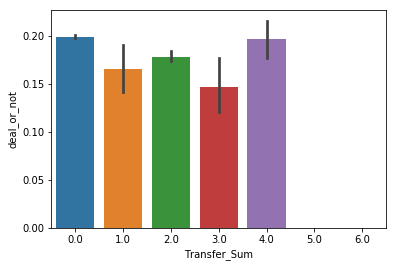

In [21]:
sns.barplot(data = data, x = 'Transfer_Sum', y = 'deal_or_not')
data.groupby(['Transfer_Sum'])['deal_or_not'].mean()

Go_Transfer_map
0.0    0.199223
1.0    0.177081
2.0    0.187974
3.0         NaN
Name: deal_or_not, dtype: float64

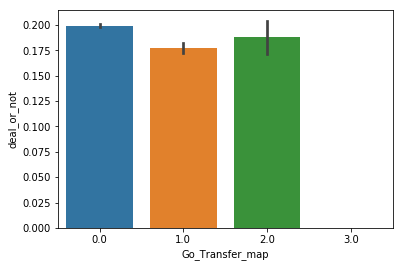

In [22]:
sns.barplot(data = data, x = 'Go_Transfer_map', y = 'deal_or_not')
data.groupby(['Go_Transfer_map'])['deal_or_not'].mean()

In [23]:
label = LabelEncoder()                                  
data['unit'] = label.fit_transform(data['unit']) 

In [24]:
# Date convertion
month = {'Jan': '01', 'Feb': '02' , 'Mar':'03' ,'Apr': '04',

'May': '05', 'Jun': '06' , 'Jul': '07' , 'Aug':'08',

'Sep':'09', 'Oct':'10' , 'Nov':'11', 'Dec':'12' }

def Convert_Date(x):
    Year='20'+x[-2:]
    Month=month[x[-6:-3]]
    Day=x[:-7]
    return pd.to_datetime(Year+'-'+Month+'-'+Day)

In [25]:
data['order_date'] = data['order_date'].apply(lambda x :Convert_Date(x))
data['begin_date'] = data['begin_date'].fillna(0)
data['begin_date'] = data['begin_date'].apply(lambda x : Convert_Date(x))

In [26]:
data['order_date_weekdday'] = data['order_date'].apply(lambda x : x .weekday())
data['begin_date_weekdday'] = data['begin_date'].apply(lambda x : x .weekday())

In [27]:
data['delta_days'] = data['days'].apply(lambda x : timedelta(days = x))
data['end_date'] = data['begin_date'] + data['delta_days']

In [28]:
data['dst_area'] = data['dst_area'].astype('str')
data['dst_area'] = label.fit_transform(data['dst_area'])

In [29]:
train = data[data['deal_or_not'].notnull()]
test  = data[data['deal_or_not'].isnull()]
train_feature = train[['source_1','people_amount','unit','dst_area','days','price']]
train_label   = train['deal_or_not']
test_feature = test[['source_1','people_amount','unit','dst_area','days','price']]

In [30]:
model(5, train_feature, train_label, test_feature, 'submission12_15_1.csv')

[0.63787792 0.6377744  0.6397957  0.63363363 0.62956849]
0.6357300309465762
[0.15736766 0.24177396 0.25608012 0.12017167 0.07010014 0.15450644]


In [31]:
# Check if hodiday
All_Holiday={
    'New Years Day' : ['2016_12_31', '2017_01_02', '2017_12_30', '2018_01_01'],
    'Chinese New Year' : ['2017_01_27', '2017_02_01', '2018_02_15', '2018_02_20'],
    '228 Peace' : ['2017_02_25', '2017_02_28', '2018_02_26', '2018_03_1'],
    'Children Qing Ming' : ['2017_04_01', '2017_04_04','2018_04_04','2018_04_08'],
    'Labor day'     : ['2017_04_29', '2017_05_01','2018_04_28','2018_05_01'],
    'Dragon Boat Festival'     : ['2017_05_27', '2017_05_30','2018_06_16','2018_06_18'],
    'Moon Festival'     : ['2017_10_03', '2017_10_05','2018_09_22','2018_09_24'],
    'National Day'  : ['2017_10_07', '2017_10_10','2018_10_09','2018_10_11'],  
}
#元旦
data['2016_12_31'] = pd.datetime(2016,12,31)
data['2017_01_02'] = pd.datetime(2017,1,2)
data['2017_12_30'] = pd.datetime(2016,12,30)
data['2018_01_01'] = pd.datetime(2016,1,1)
#春節
data['2017_01_27'] = pd.datetime(2017,1,27)
data['2017_02_01'] = pd.datetime(2017,2,1)
data['2018_02_15'] = pd.datetime(2018,2,15)
data['2018_02_20'] = pd.datetime(2018,2,20)
#和平紀念日
data['2017_02_25'] = pd.datetime(2017,2,25)
data['2017_02_28'] = pd.datetime(2017,2,28)
data['2018_02_26'] = pd.datetime(2018,2,26)
data['2018_03_1'] = pd.datetime(2018,3,1)
#兒童清明節
data['2017_04_01'] = pd.datetime(2017,4,1)
data['2017_04_04'] = pd.datetime(2017,4,4)
data['2018_04_04'] = pd.datetime(2018,4,4)
data['2018_04_08'] = pd.datetime(2018,4,8)
#勞動節
data['2017_04_29'] = pd.datetime(2017,4,29)
data['2017_05_01'] = pd.datetime(2017,5,1)
data['2018_04_28'] = pd.datetime(2018,4,28)
data['2018_05_01'] = pd.datetime(2018,5,1)
#端午節
data['2017_05_27'] = pd.datetime(2017,5,27)
data['2017_05_30'] = pd.datetime(2017,5,30)
data['2018_06_16'] = pd.datetime(2018,6,16)
data['2018_06_18'] = pd.datetime(2018,6,18)
#中秋節
data['2017_10_03'] = pd.datetime(2017,10,3)
data['2017_10_05'] = pd.datetime(2017,10,5)
data['2018_09_22'] = pd.datetime(2018,9,22)
data['2018_09_24'] = pd.datetime(2018,9,24)
#國慶雙十節
data['2017_10_07'] = pd.datetime(2017,10,7)
data['2017_10_10'] = pd.datetime(2017,10,10)
data['2018_10_09'] = pd.datetime(2018,10,9)
data['2018_10_11'] = pd.datetime(2018,10,11)
data['holiday'] = None

In [32]:
for chinese_holiday, date_column in All_Holiday.items():
    for order in range(4):
        data.loc[((data['holiday'].isna()) & (data['begin_date'] <= data[date_column[order]]) & (data[date_column[order]] <= data['end_date'])), 'holiday'] = chinese_holiday

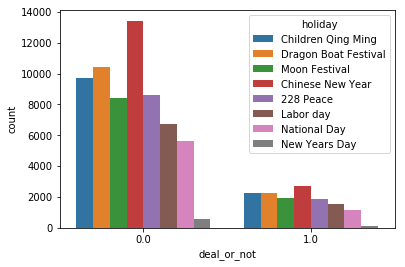

In [33]:
g = sns.countplot(data = data.loc[data['holiday'].notna() ,['deal_or_not','holiday']], hue = 'holiday' , x= 'deal_or_not')


holiday
228 Peace               0.179480
Children Qing Ming      0.191255
Chinese New Year        0.166677
Dragon Boat Festival    0.179364
Labor day               0.185176
Moon Festival           0.189494
National Day            0.173216
New Years Day           0.180575
Name: deal_or_not, dtype: float64

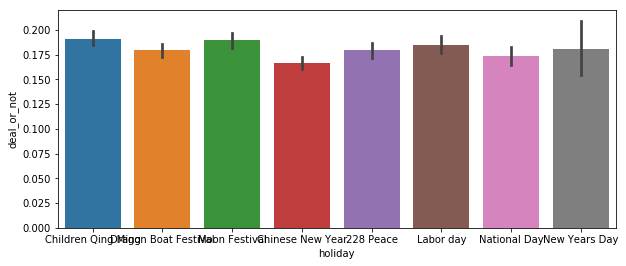

In [34]:
g = plt.figure(figsize=(10,4))
g = sns.barplot(data = data.loc[data['holiday'].notna() ,['deal_or_not','holiday']], x = 'holiday', y = 'deal_or_not')
data.groupby(['holiday'])['deal_or_not'].mean()

In [35]:
map_holiday = {
    '228 Peace' : 1,
    'Children Qing Ming' : 2,
    'Chinese New Year' : 3,
    'Dragon Boat Festival' : 4,
    'Labor day' : 5,
    'Moon Festival' : 6,
    'National Day' : 7,
    'New Years Day' : 8
}
data['is_holiday'] = data['holiday'].map(map_holiday)

In [36]:
data.drop(['2016_12_31', '2017_01_02', '2017_12_30', '2018_01_01', '2017_01_27',
       '2017_02_01', '2018_02_15', '2018_02_20', '2017_02_25', '2017_02_28',
       '2018_02_26', '2018_03_1', '2017_04_01', '2017_04_04', '2018_04_04',
       '2018_04_08', '2017_04_29', '2017_05_01', '2018_04_28', '2018_05_01',
       '2017_05_27', '2017_05_30', '2018_06_16', '2018_06_18', '2017_10_03',
       '2017_10_05', '2018_09_22', '2018_09_24', '2017_10_07', '2017_10_10',
       '2018_10_09', '2018_10_11'], inplace =True, axis = 1)

In [38]:
#Label Encoding for sub_line、area
data['sub_line'] = label.fit_transform(data['sub_line'])
data['area'] = label.fit_transform(data['area'])

In [39]:
train = data[data['deal_or_not'].notnull()]
test  = data[data['deal_or_not'].isnull()]
train_feature = train[['source_1','source_2','people_amount','sub_line','area','unit','dst_area','price']]
train_label   = train['deal_or_not']
test_feature = test[['source_1','source_2','people_amount','sub_line','area','unit','dst_area','price']]
model(5, train_feature, train_label, test_feature, 'submission12_19_0.csv')

[0.65181157 0.65395468 0.65231559 0.64996834 0.64396587]
0.6504032082067803
[0.13       0.08       0.19857143 0.07142857 0.11857143 0.21285714
 0.06857143 0.12      ]


In [40]:
data.apply(lambda x : sum(x.isnull()))

order_id                    0
group_id                    0
order_date                  0
source_1                    0
source_2                    0
unit                        0
people_amount               0
deal_or_not             99895
sub_line                    0
area                        0
days                        0
begin_date                  0
price                       0
product_name                9
promotion_prog            120
go_back                   904
fly_time                  904
src_airport               904
arrive_time               904
dst_airport               904
Go_Transfer_map           904
Back_Transfer_map         904
Transfer_Sum              904
dst_area                    0
order_date_weekdday         0
begin_date_weekdday         0
delta_days                  0
end_date                    0
holiday                287764
is_holiday             287764
dtype: int64

0.20333261967776173

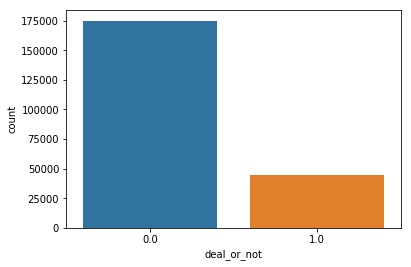

In [41]:
sns.countplot(data = data[data['is_holiday'].isna()], x='deal_or_not')
data[data['is_holiday'].isna()]['deal_or_not'].mean()

is_holiday
1.0    0.179480
2.0    0.191255
3.0    0.166677
4.0    0.179364
5.0    0.185176
6.0    0.189494
7.0    0.173216
8.0    0.180575
Name: deal_or_not, dtype: float64

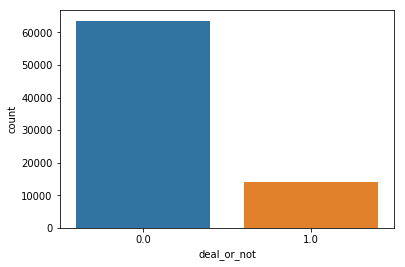

In [42]:
sns.countplot(data = data[data['is_holiday'].notna()], x='deal_or_not')
data[data['is_holiday'].notna()].groupby(['is_holiday'])['deal_or_not'].mean()

In [43]:
len(data[data['is_holiday'].notna()]), len(data[data['is_holiday'].isna()])

(109151, 287764)

In [44]:
data['holiday'].head()

0      Children Qing Ming
1      Children Qing Ming
2      Children Qing Ming
3    Dragon Boat Festival
4    Dragon Boat Festival
Name: holiday, dtype: object

In [45]:
data.loc[data['is_holiday'].notna(), 'is_holiday'] = 1 
data.loc[data['is_holiday'].isna(), 'is_holiday'] = 0 

In [46]:
data['month'] = data.begin_date.apply(lambda x : x.month)

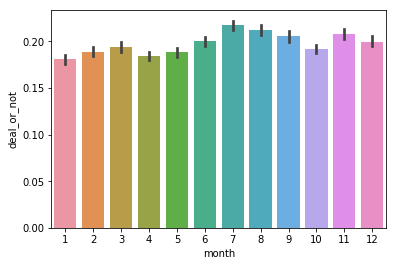

In [48]:
sns.barplot(data= data, x = 'month', y = 'deal_or_not')

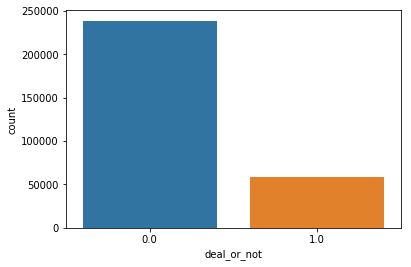

In [49]:
sns.countplot(data = train, x = 'deal_or_not')

In [52]:
train = data[data['deal_or_not'].notnull()]
test  = data[data['deal_or_not'].isnull()]
train['begin_date_weekdday'] = train['begin_date_weekdday'].astype('int32')
train['is_holiday'] = train['is_holiday'].astype('int32')

In [53]:
column = ['source_1','source_2','unit','people_amount','price','days','dst_area','begin_date_weekdday']
feature = train[column]
label   = train['deal_or_not']
feature_train, feature_cv, label_train, label_cv = train_test_split(feature, label, test_size =0.2, random_state = 42, shuffle =True)

In [54]:
model(5, feature_train[column], label_train, test[column], 'delete.csv')

[0.64709309 0.64622178 0.65081863 0.6451014  0.64310146]
0.6464672691321093
[0.10729614 0.07725322 0.2274678  0.20600858 0.1602289  0.07010014
 0.11444921 0.037196  ]


# Sampling and Model

In [56]:
#RandomUnderSampler

In [57]:
RUS = RandomUnderSampler(random_state=42)
x_sample, y_sample = RUS.fit_sample(feature_train, label_train)

In [58]:
len(x_sample),len(y_sample)

(93940, 93940)

In [59]:
x = pd.DataFrame(data = x_sample, columns = column)
y = pd.DataFrame(data = y_sample, columns=['deal_or_not'])
final_data = pd.concat([x,y], axis= 1)

In [60]:
xgb = XGBClassifier(random_state= 42)
xgb.fit(final_data[['source_1','source_2','unit','people_amount','dst_area']], final_data['deal_or_not'])
#print(forest.oob_score_)
print(xgb.score(feature_cv[['source_1','source_2','unit','people_amount','dst_area']], label_cv))
print(xgb.feature_importances_)

0.6868224361995825
[0.14115898 0.07726597 0.31203565 0.29123327 0.17830609]


In [61]:
model(5, final_data[['source_1','source_2','unit','people_amount','dst_area']], final_data['deal_or_not'], test[['source_1','source_2','unit','people_amount','dst_area']], 'submission12_20_01.csv')

[0.6408197  0.64655858 0.64784553 0.64498426 0.64141807]
0.644325227364628
[0.14115898 0.07726597 0.31203565 0.29123327 0.17830609]


In [63]:
#Smote

In [65]:
Sm = SMOTE(random_state=42)
x_sample, y_sample = Sm.fit_sample(feature_train, label_train)

In [66]:
x = pd.DataFrame(data = x_sample, columns = column)
y = pd.DataFrame(data = y_sample, columns=['deal_or_not'])
final_data = pd.concat([x,y], axis= 1)

In [67]:
len(final_data)

381292

In [68]:
xgb = XGBClassifier(random_state= 42)
xgb.fit(final_data[column], final_data['deal_or_not'])
#print(forest.oob_score_)
print(xgb.score(feature_cv[column], label_cv))
print(xgb.feature_importances_)

0.8150797926065585
[0.17595308 0.08357771 0.07038123 0.28005865 0.05278593 0.05865103
 0.05865103 0.21994135]


In [69]:
len(final_data)

381292

In [70]:
model(5, final_data[column], final_data['deal_or_not'], test[column], 'submission12_20_02.csv')

[0.88480646 0.88465958 0.88058088 0.88535142 0.88126214]
0.8833320954402378
[0.17595308 0.08357771 0.07038123 0.28005865 0.05278593 0.05865103
 0.05865103 0.21994135]
